# Fisher's Linear Discriminant

## Loading Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
df = pd.read_csv("dataset_FLD.csv",header = None)
df.columns = ["feature 1","feature 2", "feature 3","label"]

In [3]:
df

,feature 1,feature 2,feature 3,label
0,-6.672418,-1.206198,-1.081050,0
1,1.675598,0.614994,-0.971600,0
2,-4.039058,0.335102,0.544618,1
3,0.793526,-0.235277,0.551771,1
4,3.820273,-0.274691,0.454743,1
...,...,...,...,...
995,-3.680139,0.966962,-0.904337,0
996,-4.063900,0.802611,1.023708,1
997,-0.814430,-0.693945,0.876776,1
998,-0.325122,-0.759024,1.299772,1


In [4]:
data = df.values
X = data[:,:-1]
y = data[:,-1]

In [5]:
# .values converts the dataframe into numpy array
positives = df[df["label"] == 1].values
negatives = df[df["label"] == 0].values

## Visualize Data

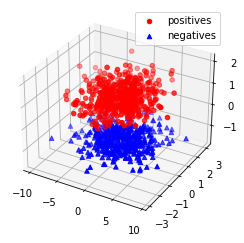

In [42]:
ax = plt.axes(projection='3d')
ax.scatter3D(positives[:,0], positives[:,1], positives[:,2], c='r',marker='o')
ax.scatter3D(negatives[:,0], negatives[:,1], negatives[:,2], c='b',marker='^')
plt.legend(['positives','negatives'])
plt.show()

In [7]:
labels = np.unique(df['label'].values)
features = X.shape[1]

# initialize S_w and S_b as zero matrices
S_w = np.zeros((features,features))
S_b = np.zeros((features,features))

positive_mean = np.mean(X[y==1],axis=0)
negative_mean = np.mean(X[y==0],axis=0)

dataset_mean = np.mean(X,axis=0)

# go through both the classes
for label in labels:
    # collect data with that label
    X_class = X[y==label]
    
    mu_c = np.mean(X_class,axis=0)
    # (500,3)*(3,500) = (3,3)
    S_w += (X_class - mu_c).T.dot((X_class - mu_c))
    

In [8]:
mean_difference = (positive_mean - negative_mean).reshape(features,1)
w = np.linalg.inv(S_w).dot(mean_difference)

In [9]:
positive_projections = X[y==1].dot(w)
negative_projections = X[y==0].dot(w)

## Plot of the normal distributions of the pdf's

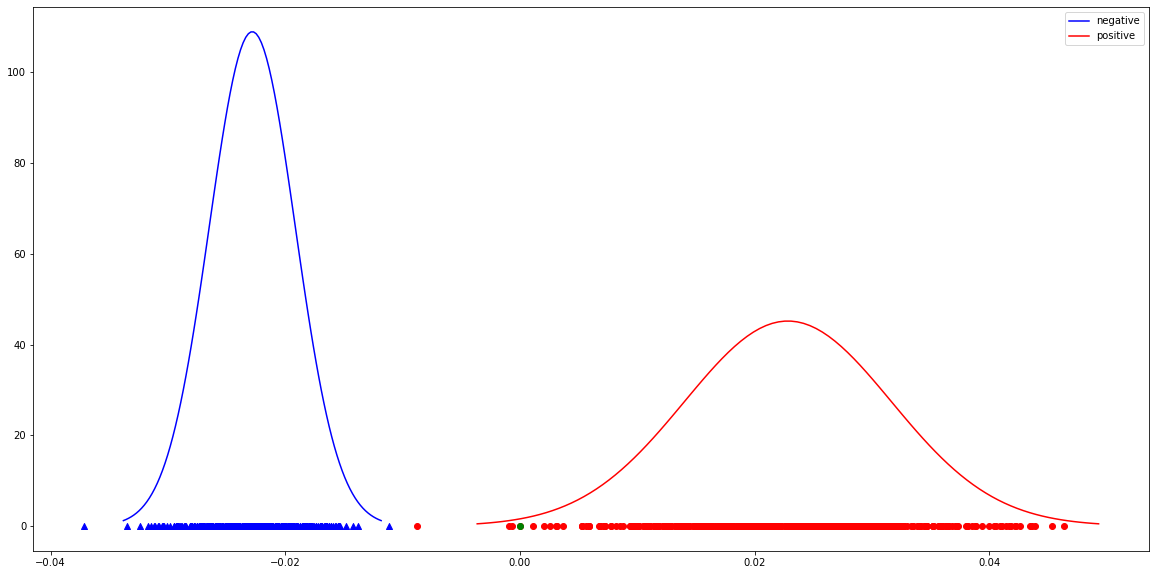

In [40]:
def show_gaussians(X):
    colors = ['b','r']
    markers = ['^','o']
    plt.figure(figsize=(20, 10))
    # go through each class
    for i,label in enumerate(labels):
        # find corresponding projections of that class
        label_projections = X[y==label].dot(w)
        # mean of projections
        label_projections_mean = np.mean(label_projections)
        # std of projections
        label_projections_std = np.std(label_projections)
        # here we are taking data upto 3 standard deviations, i.e approx 95% of the data iirc
        x_data = np.linspace(label_projections_mean - 3*label_projections_std, label_projections_mean + 3*label_projections_std, 100)
        plt.plot(x_data, stats.norm.pdf(x_data, label_projections_mean, label_projections_std),c=colors[i])
        plt.scatter(label_projections,np.zeros_like(label_projections),c=colors[i],marker=markers[i])
        # green point is threshold
    plt.scatter(np.array([threshold]),np.zeros_like(np.array([threshold])),c='g')
    plt.legend(['negative','positive'])
    plt.show()

show_gaussians(X)

In [25]:
# -0.5*(m1+m2)
threshold = -0.5*(np.mean(X[y==0].dot(w)) + np.mean(X[y==1].dot(w)))

In [41]:
threshold

array([-1.21611899e-05])